* Nama: Ichsan Setiawan
* NIM: 25/562584/PPA/07067
* Kelas: Computer Vision Lanjut
* Dosen Pengampu: Wahyono, S.Kom., Ph.D.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/shapes_v1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import json, os

# buka file JSON
with open(os.path.join(base_dir, "annotation.json"), "r") as f:
    data = json.load(f)

# lihat struktur utama
keys_list = list(data.keys())

print(', '.join(keys_list))

0.png, 1.png, 2.png, 3.png, 4.png, 5.png, 6.png, 7.png, 8.png, 9.png, 10.png, 11.png, 12.png, 13.png, 14.png, 15.png, 16.png, 17.png, 18.png, 19.png, 20.png, 21.png, 22.png, 23.png, 24.png, 25.png, 26.png, 27.png, 28.png, 29.png, 30.png, 31.png, 32.png, 33.png, 34.png, 35.png, 36.png, 37.png, 38.png, 39.png, 40.png, 41.png, 42.png, 43.png, 44.png, 45.png, 46.png, 47.png, 48.png, 49.png, 50.png, 51.png, 52.png, 53.png, 54.png, 55.png, 56.png, 57.png, 58.png, 59.png, 60.png, 61.png, 62.png, 63.png, 64.png, 65.png, 66.png, 67.png, 68.png, 69.png, 70.png, 71.png, 72.png, 73.png, 74.png, 75.png, 76.png, 77.png, 78.png, 79.png, 80.png, 81.png, 82.png, 83.png, 84.png, 85.png, 86.png, 87.png, 88.png, 89.png, 90.png, 91.png, 92.png, 93.png, 94.png, 95.png, 96.png, 97.png, 98.png, 99.png, 100.png, 101.png, 102.png, 103.png, 104.png, 105.png, 106.png, 107.png, 108.png, 109.png, 110.png, 111.png, 112.png, 113.png, 114.png, 115.png, 116.png, 117.png, 118.png, 119.png, 120.png, 121.png, 122.png, 123

In [12]:
# Access the first element using its key
data[keys_list[0]]

[{'box': [200, 44, 247, 129], 'category': 'rectangle'},
 {'box': [57, 122, 126, 159], 'category': 'rectangle'},
 {'box': [143, 289, 231, 377], 'category': 'circle'},
 {'box': [273, 176, 342, 300], 'category': 'rectangle'},
 {'box': [188, 192, 260, 264], 'category': 'circle'},
 {'box': [246, 308, 307, 347], 'category': 'rectangle'},
 {'box': [351, 73, 410, 114], 'category': 'rectangle'}]

In [13]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img_dir = os.path.join(base_dir, "images")

img_keys = sorted(data.keys(), key=lambda x: int(os.path.splitext(x)[0]))

# Menghitung IoU
def box_iou(boxA, boxB):
    xa1, ya1, xa2, ya2 = boxA
    xb1, yb1, xb2, yb2 = boxB

    xi1 = max(xa1, xb1); yi1 = max(ya1, yb1)
    xi2 = min(xa2, xb2); yi2 = min(ya2, yb2)

    iw = max(0, xi2 - xi1); ih = max(0, yi2 - yi1)
    inter = iw * ih

    areaA = max(0, xa2-xa1) * max(0, ya2-ya1)
    areaB = max(0, xb2-xb1) * max(0, yb2-yb1)
    union = areaA + areaB - inter
    return inter/union if union>0 else 0.0

In [14]:
def rgb_distance_mask(img, target_rgb, thresh=0.25):
    diff = img - np.array(target_rgb).reshape(1,1,3)
    dist = np.sqrt((diff**2).sum(axis=-1))
    return (dist <= thresh).astype(np.uint8)

# Implementasi CCL Manual

def extract_bboxes_ccl(mask, min_area_threshold=10):
    rows, cols = mask.shape
    visited = np.zeros_like(mask, dtype=bool)
    bboxes = []

    for r in range(rows):
        for c in range(cols):
            if mask[r, c] == 1 and not visited[r, c]:
                component_pixels = []
                queue = [(r, c)] # Start BFS Queue
                visited[r, c] = True

                min_r, max_r = r, r
                min_c, max_c = c, c

                while queue:
                    curr_r, curr_c = queue.pop(0) # FIFO (Queue/BFS)
                    component_pixels.append((curr_r, curr_c))

                    # Update batas komponen
                    min_r = min(min_r, curr_r)
                    max_r = max(max_r, curr_r)
                    min_c = min(min_c, curr_c)
                    max_c = max(max_c, curr_c)

                    # Cek 8 tetangga (8-connectivity)
                    for dr in [-1, 0, 1]:
                        for dc in [-1, 0, 1]:
                            if dr == 0 and dc == 0: continue

                            next_r, next_c = curr_r + dr, curr_c + dc

                            if 0 <= next_r < rows and 0 <= next_c < cols:
                                if mask[next_r, next_c] == 1 and not visited[next_r, next_c]:
                                    visited[next_r, next_c] = True
                                    queue.append((next_r, next_c))

                # Cek ukuran komponen
                if len(component_pixels) >= min_area_threshold:
                    x1, y1 = min_c, min_r
                    x2, y2 = max_c, max_r
                    bboxes.append([int(x1), int(y1), int(x2), int(y2)])

    return bboxes

In [15]:
# Greedy matching untuk menghitung TP/FP/FN
def match_preds_to_gts(pred_boxes, gt_boxes, iou_thresh=0.5):
    matches = []
    used_pred, used_gt = set(), set()
    if len(pred_boxes)==0 or len(gt_boxes)==0:
        return [], list(range(len(pred_boxes))), list(range(len(gt_boxes)))

    # Hitung Matriks IoU
    iou_mat = np.zeros((len(pred_boxes), len(gt_boxes)), dtype=float)
    for i,p in enumerate(pred_boxes):
        for j,g in enumerate(gt_boxes):
            iou_mat[i,j] = box_iou(p,g)

    # Greedy max matching
    while True:
        # Cari IoU tertinggi yang belum di-match
        idx = np.unravel_index(np.argmax(iou_mat), iou_mat.shape)
        i,j = idx

        # Hentikan jika IoU tertinggi <= 0
        if iou_mat[i,j] <= 0:
            break

        # Catat Match
        matches.append((i,j,iou_mat[i,j]))

        # Tandai baris (pred) dan kolom (gt) yang sudah di-match dengan nilai -1
        iou_mat[i,:] = -1
        iou_mat[:,j] = -1

    # Hitung yang tidak match
    used_pred = {m[0] for m in matches}
    used_gt = {m[1] for m in matches}
    unmatched_preds = [i for i in range(len(pred_boxes)) if i not in used_pred]
    unmatched_gts = [j for j in range(len(gt_boxes)) if j not in used_gt]

    return matches, unmatched_preds, unmatched_gts

In [16]:
prototypes = {
    "red": (1.0, 0.0, 0.0),
    "green": (0.0, 1.0, 0.0),
    "blue": (0.0, 0.0, 1.0),
}
color_thresh = 0.3 # Ambang batas jarak Euclidean RGB

# Evaluasi pada sampel gambar
sample_ids = img_keys[:100]
TP = FP = FN = 0
iou_vals = []

for key in sample_ids:
    img_path = os.path.join(img_dir, key)
    img = mpimg.imread(img_path).astype(np.float32)
    if img.max() > 1.0:
        img = img / 255.0

    preds = []
    for cname, proto in prototypes.items():
        mask = rgb_distance_mask(img, proto, thresh=color_thresh)

        boxes = extract_bboxes_ccl(mask)

        for b in boxes:
            preds.append({"bbox": b, "color": cname})

    # Ground truth boxes dari annotation.json (format: [x1,y1,x2,y2])
    gts = []
    for entry in data[key]:
        gbox = entry["box"]
        # Pastikan format [x1,y1,x2,y2]
        gts.append({"bbox":[int(gbox[0]), int(gbox[1]), int(gbox[2]), int(gbox[3])], "category": entry.get("category","")})

    pred_boxes = [p["bbox"] for p in preds]
    gt_boxes_raw = [g["bbox"] for g in gts]

    matches, unmatched_preds, unmatched_gts = match_preds_to_gts(pred_boxes, gt_boxes_raw, iou_thresh=0.5)

    # Hitung TP/FP/FN
    tp = sum(1 for (_,_,iou) in matches if iou >= 0.5)
    fp = len(unmatched_preds) + sum(1 for (_,_,iou) in matches if iou < 0.5)
    fn = len(unmatched_gts) + sum(1 for (_,_,iou) in matches if iou < 0.5)

    TP += tp; FP += fp; FN += fn
    iou_vals.extend([m[2] for m in matches if m[2] >= 0.5])

Eval on 100 images
Total GT: 604
TP: 597 FP: 2 FN: 7
precision: 0.9967, recall: 0.9884, f1: 0.9925, mean_iou: 0.9977


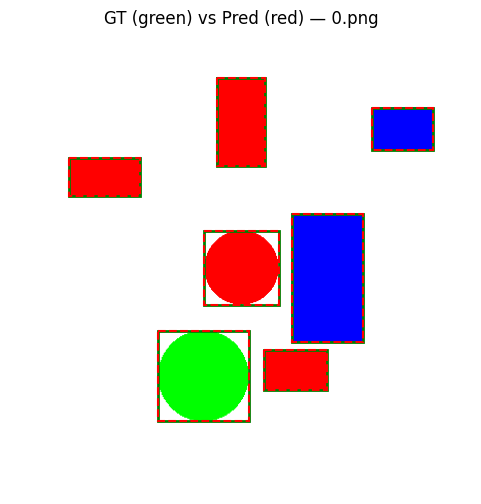

In [17]:
# Hitung metrik akhir
precision = TP / (TP + FP + 1e-9)
recall = TP / (TP + FN + 1e-9)
f1 = 2*precision*recall/(precision+recall+1e-9)
mean_iou = np.mean(iou_vals) if len(iou_vals)>0 else 0.0

print("Eval on {} images".format(len(sample_ids)))
print("Total GT: {}".format(TP + FN))
print("TP:",TP,"FP:",FP,"FN:",FN)
print("precision: {:.4f}, recall: {:.4f}, f1: {:.4f}, mean_iou: {:.4f}".format(precision, recall, f1, mean_iou))

# Visualisasi
if sample_ids:
    vis_key = sample_ids[0]
    img = mpimg.imread(os.path.join(img_dir, vis_key)).astype(np.float32)
    if img.max() > 1.0:
        img = img/255.0

    pred_boxes_display = []
    for cname, proto in prototypes.items():
        mask = rgb_distance_mask(img, proto, thresh=color_thresh)

        # Gunakan CCL
        boxes = extract_bboxes_ccl(mask)

        for b in boxes:
            pred_boxes_display.append((b, cname))

    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.imshow(img)
    ax.set_title(f"GT (green) vs Pred (red) — {vis_key}")
    ax.axis("off")

    for entry in data[vis_key]:
        x1,y1,x2,y2 = entry["box"]
        rect = plt.Rectangle((x1,y1), x2-x1, y2-y1, edgecolor="g", facecolor="none", linewidth=2)
        ax.add_patch(rect)

    for (b,cname) in pred_boxes_display:
        x1,y1,x2,y2 = b
        rect = plt.Rectangle((x1,y1), x2-x1, y2-y1, edgecolor="r", facecolor="none", linewidth=1.5, linestyle="--")
        ax.add_patch(rect)

    plt.show()